In [1]:
import numpy as np 
import time 
import cftime
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray 

In [3]:
plt.rcParams['font.size'] = '6'

In [48]:

linestyle_dict = {
     'solid':                 'solid',
     'loosely dotted':        (0, (1, 10)),
     'dotted':                (0, (1, 1)),
     'densely dotted':        (0, (1, 1)),
     'long dash with offset': (5, (10, 3)),
     'loosely dashed':        (0, (5, 10)),
     'dashed':                (0, (5, 5)),
     'densely dashed':        (0, (5, 1)),

     'loosely dashdotted':    (0, (3, 10, 1, 10)),
     'dashdotted':            (0, (3, 5, 1, 5)),
     'densely dashdotted':    (0, (3, 1, 1, 1)),

     'dashdotdotted':         (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1))}

def plot_ds12_diff(ds_list,level = np.arange(0,300,10), dlevel = np.arange(-5,5.1,0.5)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten()
    for i in range(2):
        ax=axs[i]
        da = ds_list[i]
        da.plot(ax=ax, levels=level, extend='both')  
        ax.set_title(f'{da.name} GM: {global_mean_xarray(da).values:4.2f}') 
    ax=axs[2]
    da = ds_list[1]-ds_list[0]
    da.plot(ax=ax, levels=dlevel, extend='both') 
    # ax.set_title(f'diff mean: {(da.mean()).values:4.2f}')  
    ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()  
def plot_zonal_ta_diff(ds_list,level = np.arange(200,330,10), dlevel = np.arange(-3,3.1,0.5)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten()
    for i in range(2):
        ax=axs[i]
        da = ds_list[i]
        da.plot(ax=ax, levels=level, extend='both')  
        ax.set_title(f'{da.name} mean: {(da.mean()).values:4.2f}')  
    ax=axs[2]
    da = (ds_list[1]-ds_list[0])
    da.plot(ax=ax, levels=dlevel, extend='both') 
    ax.set_title(f'diff mean: {(da.mean()).values:4.2f}')  
    # ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
        ax.invert_yaxis()
    fig.tight_layout()  

def plot_zonal_tdt_diff(ds_list,level = np.arange(-2,2,0.1), dlevel = np.arange(-0.5,0.51,0.05)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten()
    for i in range(2):
        ax=axs[i]
        da = ds_list[i]
        da.plot(ax=ax, levels=level, extend='both')  
        ax.set_title(f'{da.name} mean: {(da.mean()).values:4.2f} [K/day]')  
    ax=axs[2]
    da = (ds_list[1]-ds_list[0])
    da.plot(ax=ax, levels=dlevel, extend='both') 
    ax.set_title(f'diff mean: {(da.mean()).values:4.2f} [K/day]')   
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
        ax.invert_yaxis()
    fig.tight_layout()  

def plot_GM_diff(ds_list,var_info):
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(3,2),dpi=200)
    ax=axs
    linesty = ['-', '--', ':']
    for i in range(len(ds_list)): 
        # da = global_mean_xarray(ds_list[i].groupby('time.year').mean('time'))
        # ax.plot(da.year,da) 
        da = global_mean_xarray(ds_list[i])
        # timeaxis = da.indexes['time'].to_datetimeindex()
        timeaxis = [cftime.date2num(_, 'months since 0001-01-01',calendar='360_day')/12 
                    for _ in da.time.data]
        ax.plot(timeaxis,da,linestyle=linesty[i]) 
    if len(var_info) == 2: 
        ax.set_title(f'{var_info[0]} | {var_info[1]} = {da[var_info[1]].data}')   
    else:
        ax.set_title(f'{var_info}') 
    fig.tight_layout()  
    
def plot_GM_bias_mse_rmse_diff(ds,var,var_info):
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(3,2),dpi=200)
    ax=axs
    linesty = [linestyle_dict['solid'], linestyle_dict['dashed']]
    e_type = ['bias','mse','rmse']
    for i in range(3): 
        # raw errors
        da = global_mean_xarray(ds[f'{e_type[i]}_{var}']).groupby('time.year').mean()
        # timeaxis = da.indexes['time'].to_datetimeindex()
        timeaxis = [cftime.date2num(_, 'months since 0001-01-01',calendar='360_day')/12 
                    for _ in ds.time.data[::12]]
        p = ax.plot(timeaxis,da,linestyle=linesty[0],linewidth=1,label = e_type[i]) 
        # adjusted errors
        c = p[0].get_color()
        da = global_mean_xarray(ds[f'adj_{e_type[i]}_{var}']).groupby('time.year').mean()
        ax.plot(timeaxis,da,linestyle=linesty[1],linewidth=2,color=c,label = f'adj_{e_type[i]}') 
    if len(var_info) == 2: 
        ax.set_title(f'{var_info[0]} | {var_info[1]} = {da[var_info[1]].data}')   
    else:
        ax.set_title(f'{var_info}') 
    ax.legend()
    fig.tight_layout()  
def plot_tropics_bias_mse_rmse_diff(ds,var,var_info):
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(3,2),dpi=200)
    ax=axs
    linesty = [linestyle_dict['solid'], linestyle_dict['dashed']]
    e_type = ['bias','mse','rmse']
    for i in range(3): 
        # raw errors
        da = global_mean_xarray(ds[f'{e_type[i]}_{var}'].sel(lat=slice(-30,30))).groupby('time.year').mean()
        # timeaxis = da.indexes['time'].to_datetimeindex()
        timeaxis = [cftime.date2num(_, 'months since 0001-01-01',calendar='360_day')/12 
                    for _ in ds.time.data[::12]]
        p = ax.plot(timeaxis,da,linestyle=linesty[0],linewidth=1,label = e_type[i]) 
        # adjusted errors
        c = p[0].get_color()
        da = global_mean_xarray(ds[f'adj_{e_type[i]}_{var}'].sel(lat=slice(-30,30))).groupby('time.year').mean()
        ax.plot(timeaxis,da,linestyle=linesty[1],linewidth=2,color=c,label = f'adj_{e_type[i]}') 
    if len(var_info) == 2: 
        ax.set_title(f'{var_info[0]} | {var_info[1]} = {da[var_info[1]].data}')   
    else:
        ax.set_title(f'{var_info}') 
    ax.legend()
    fig.tight_layout()  
    

#  import datacolors

In [5]:
year_list = np.arange(1965,1985)

# 3 hourly

In [6]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_sst0.5Kperyear_nn_stellarcpu_intelmpi_22_768PE/'
ds = xr.open_mfdataset([file_path+f'POSTP/{year}0101.atmos_8xdaily.nc.monavg_error.nc' for year in year_list],
                      chunks={"pfull": 1}, parallel=True)  
ds_nn_3h = ds.rename({'grid_yt':'lat','grid_xt':'lon'}).load()

file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_sst0.5Kperyear_nn_stellarcpu_intelmpi_22_768PE_base/' 
ds = xr.open_mfdataset([file_path+f'POSTP/{year}0101.atmos_8xdaily.nc.monavg_error.nc' for year in year_list],
                      chunks={"pfull": 1}, parallel=True)  
ds_ba_3h = ds.rename({'grid_yt':'lat','grid_xt':'lon'}).load()

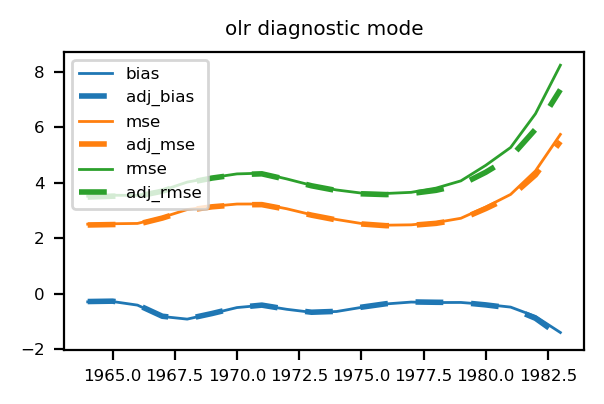

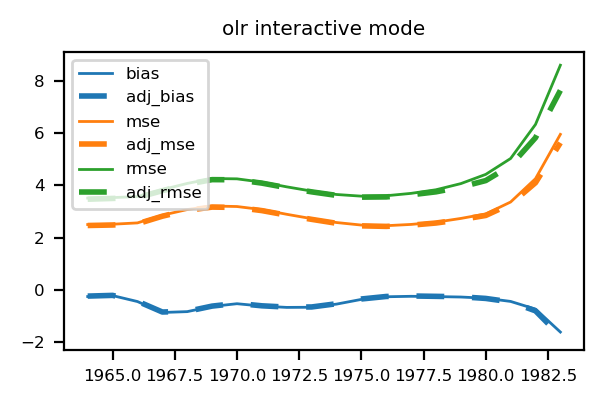

In [41]:
plot_GM_bias_mse_rmse_diff(ds_ba_3h,'olr','olr diagnostic mode')

plot_GM_bias_mse_rmse_diff(ds_nn_3h,'olr','olr interactive mode')

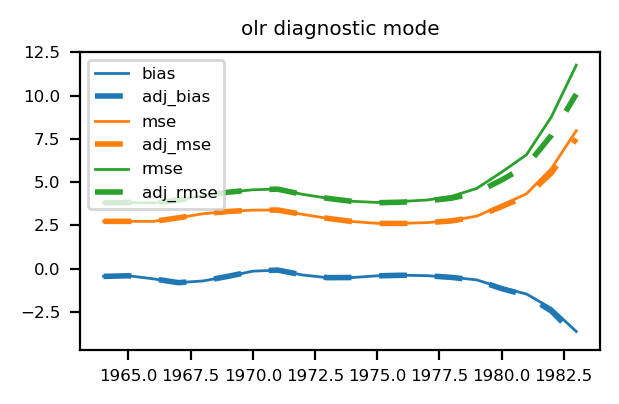

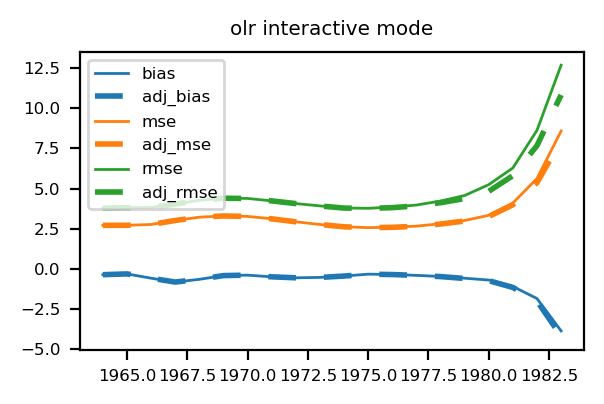

In [49]:
plot_tropics_bias_mse_rmse_diff(ds_ba_3h,'olr','olr diagnostic mode')

plot_tropics_bias_mse_rmse_diff(ds_nn_3h,'olr','olr interactive mode')

GM trend


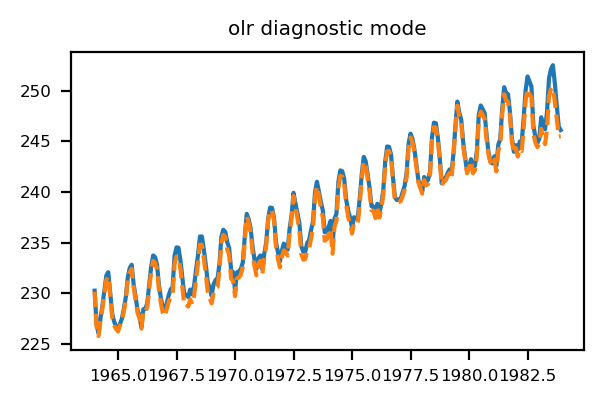

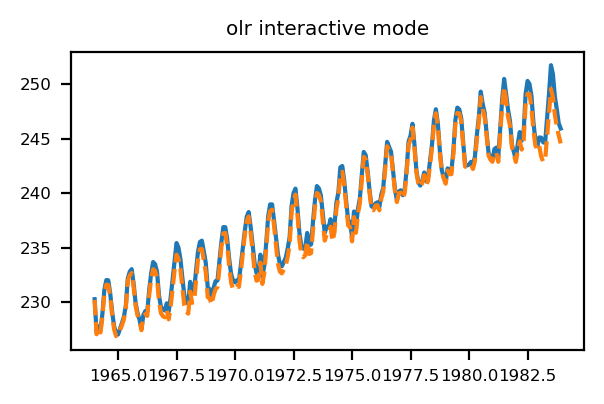

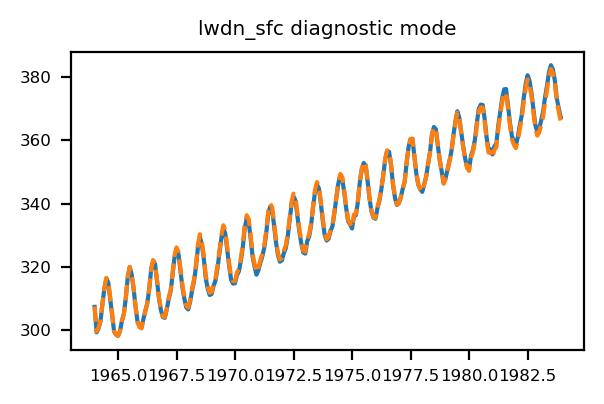

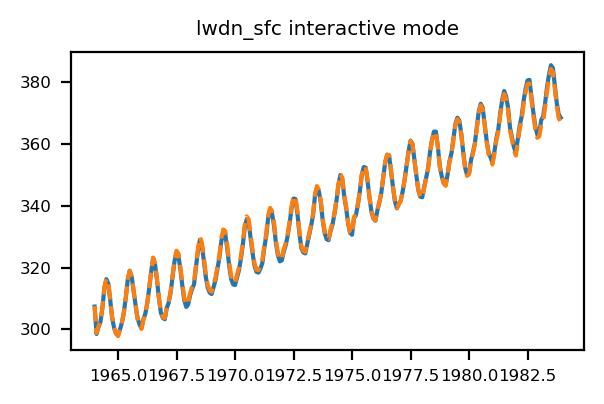

In [46]:
var = 'olr' 
print('GM trend') 
ds_list = [ds_ba_3h[var],
           ds_ba_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' diagnostic mode') 
ds_list = [ds_nn_3h[var],
           ds_nn_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' interactive mode') 
var = 'lwdn_sfc'  
ds_list = [ds_ba_3h[var],
           ds_ba_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' diagnostic mode') 
ds_list = [ds_nn_3h[var],
           ds_nn_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' interactive mode') 

cold test


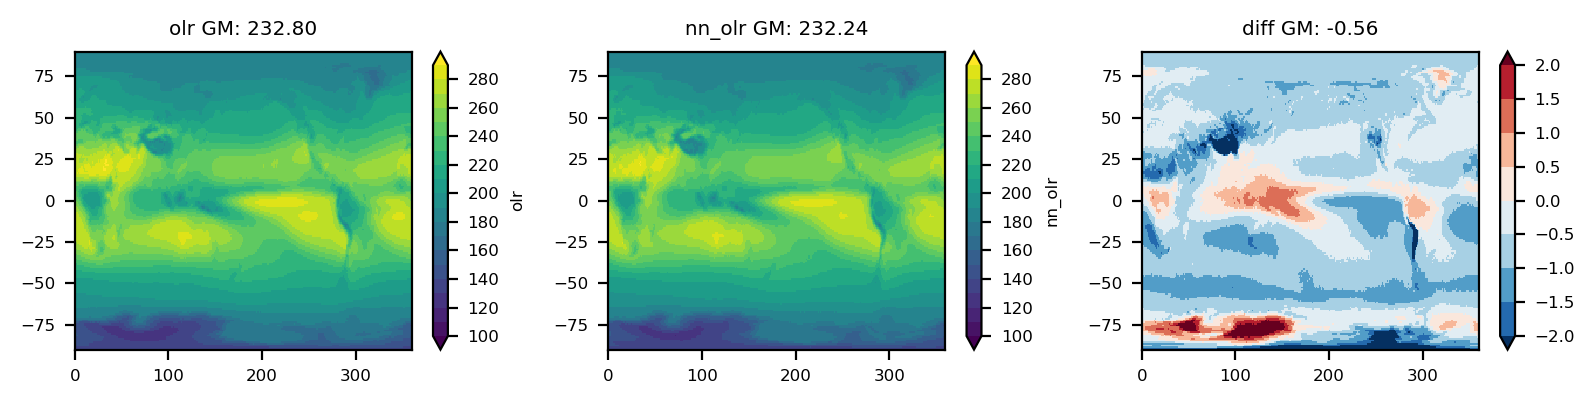

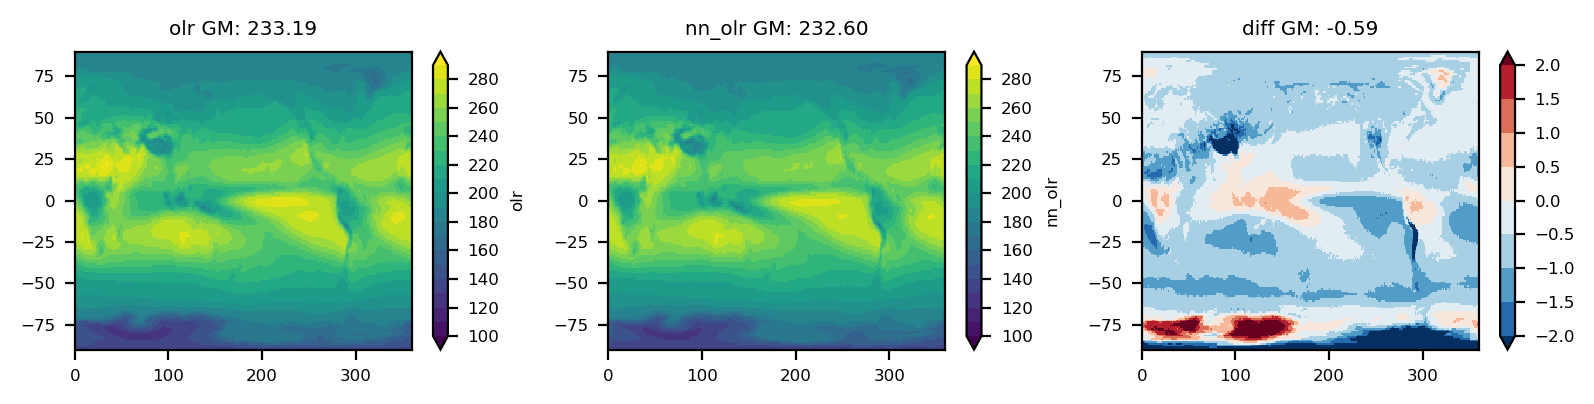

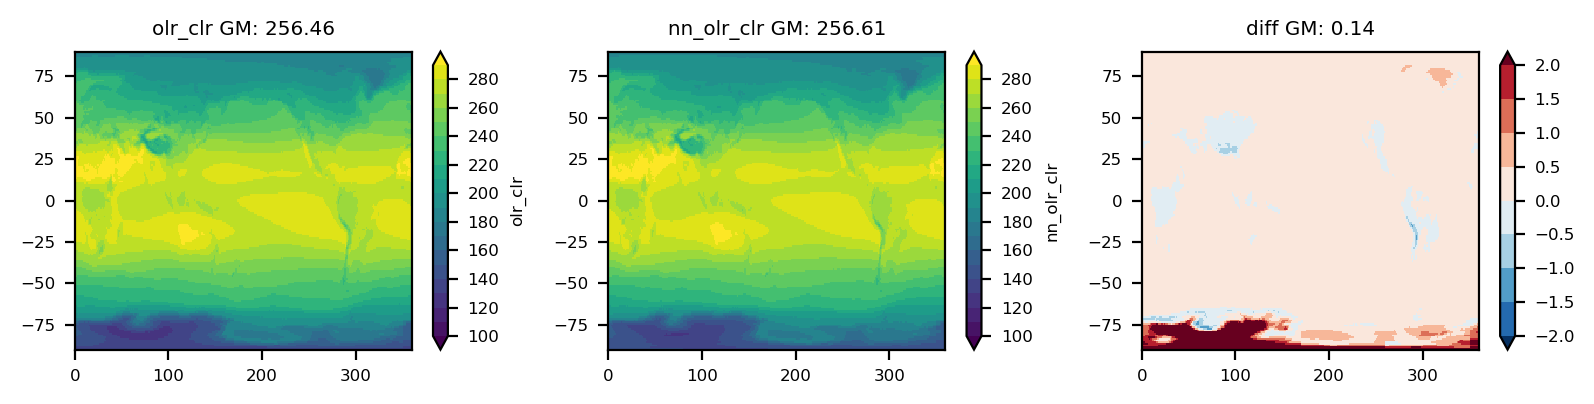

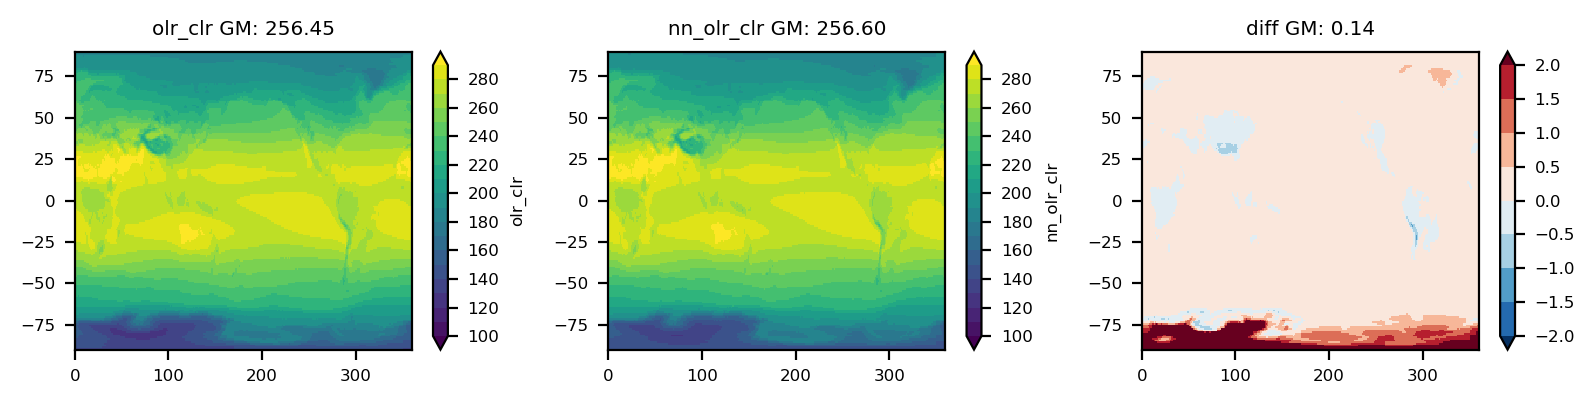

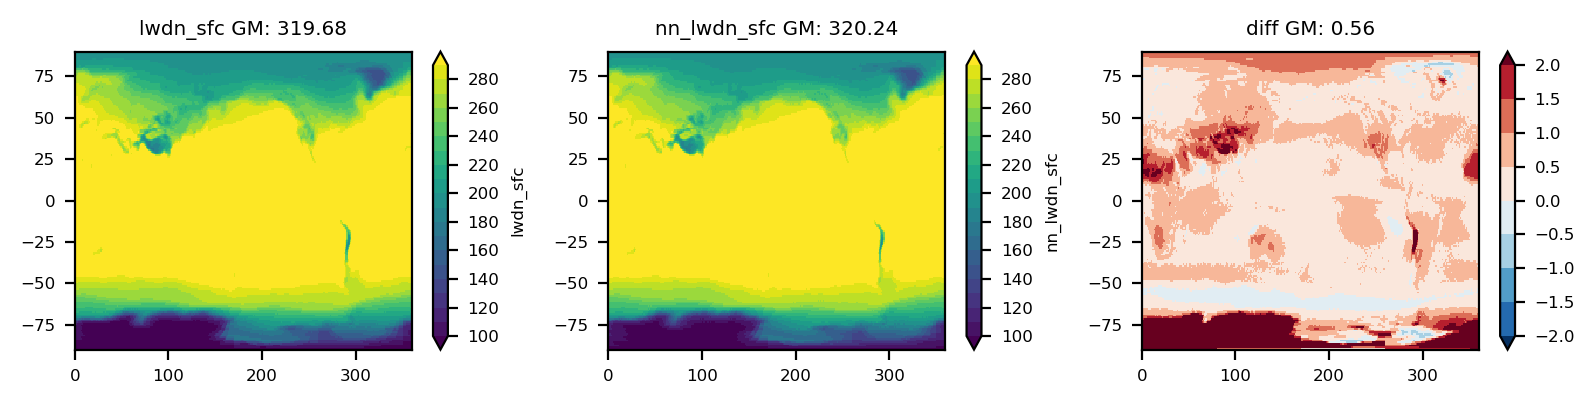

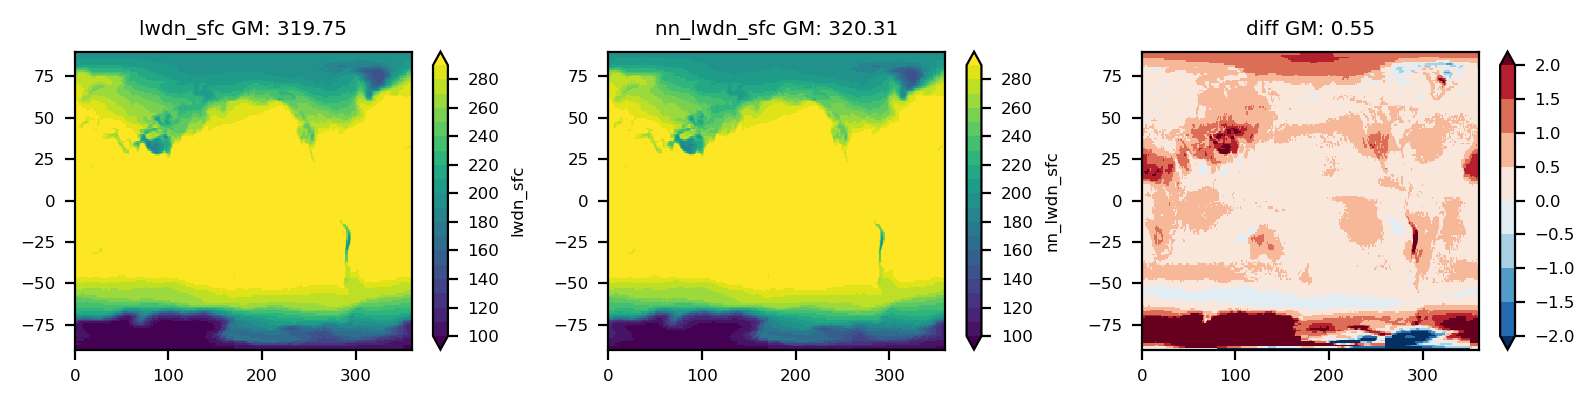

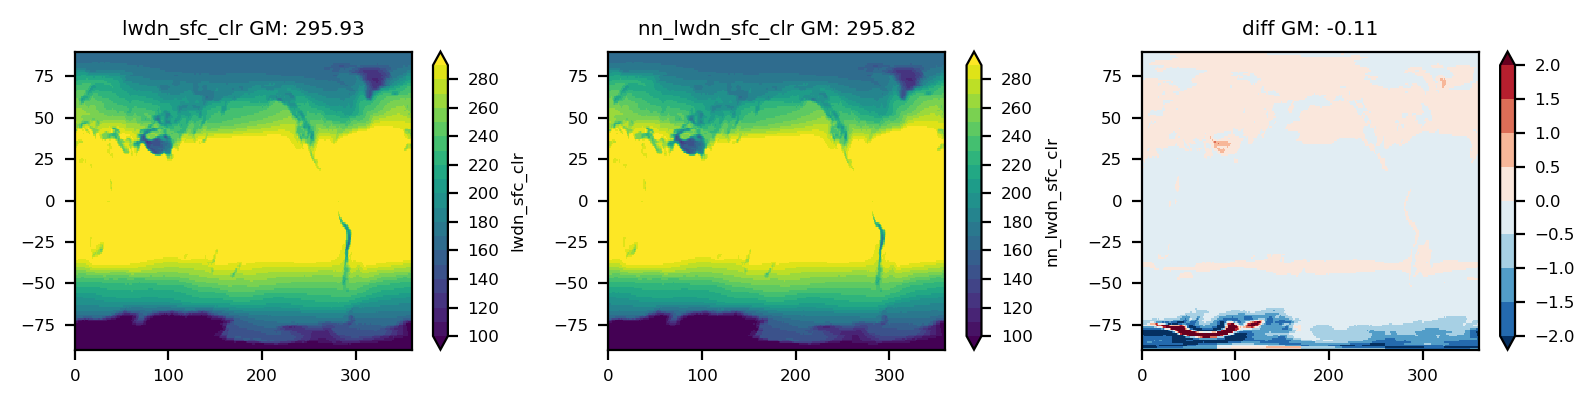

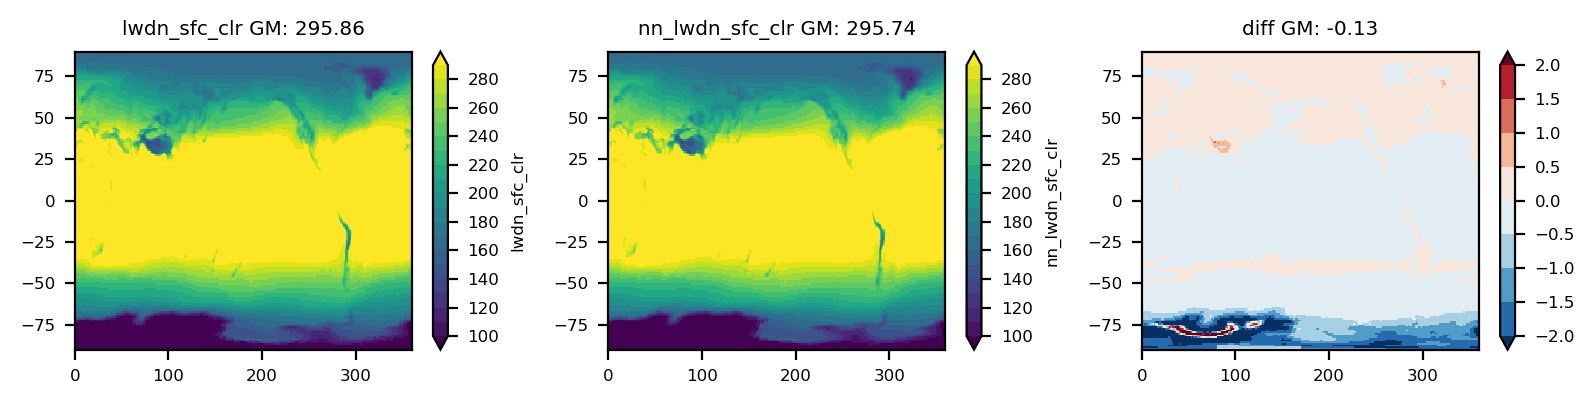

In [11]:
year_sel=np.arange(1965,1975)
time_sel = ds_nn_3h.time.dt.year.isin(year_sel)
print('cold test')
ds_list = [ds_ba_3h['olr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_olr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['olr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_olr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['olr_clr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_olr_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['olr_clr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_olr_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['lwdn_sfc'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_lwdn_sfc'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['lwdn_sfc'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_lwdn_sfc'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['lwdn_sfc_clr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_lwdn_sfc_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['lwdn_sfc_clr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_lwdn_sfc_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 

warm test


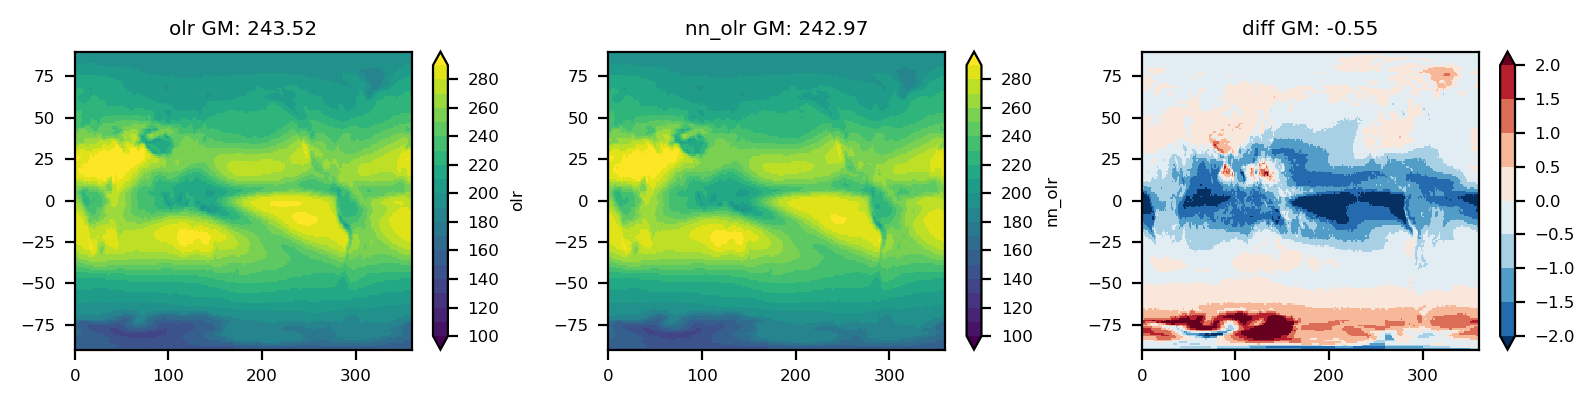

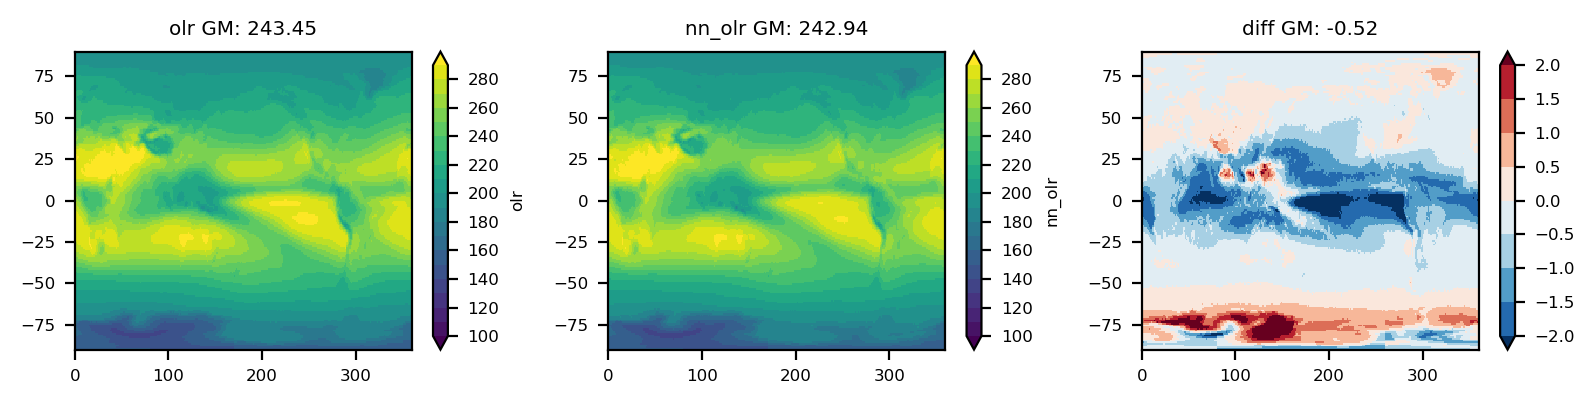

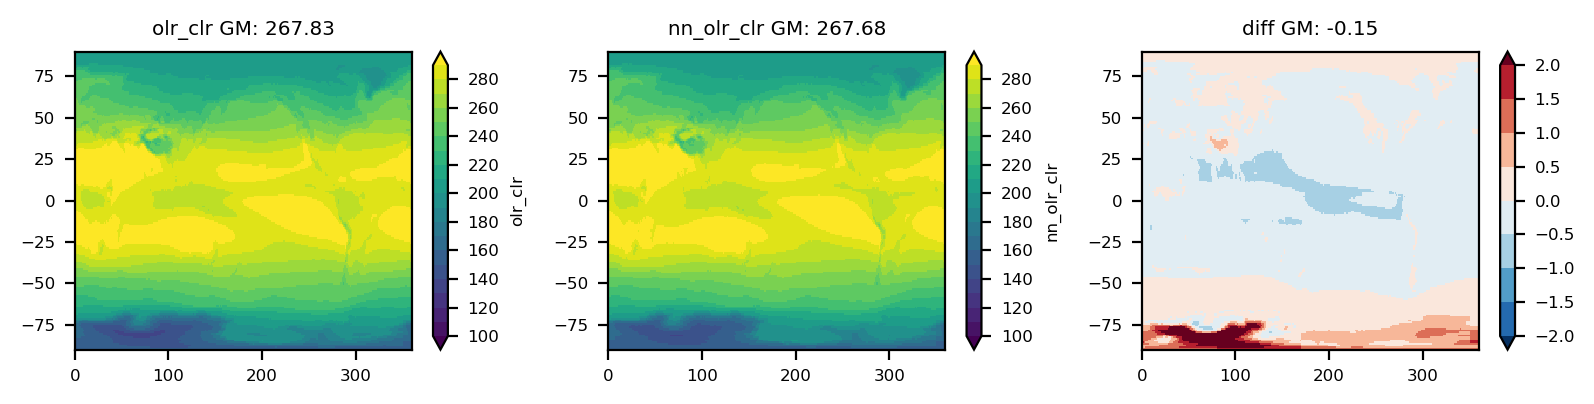

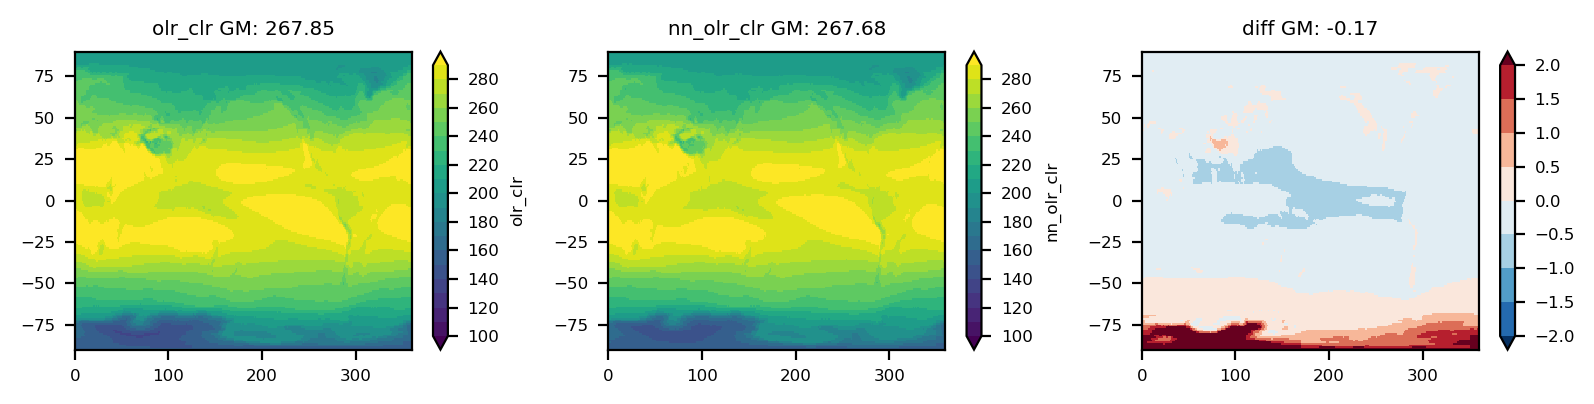

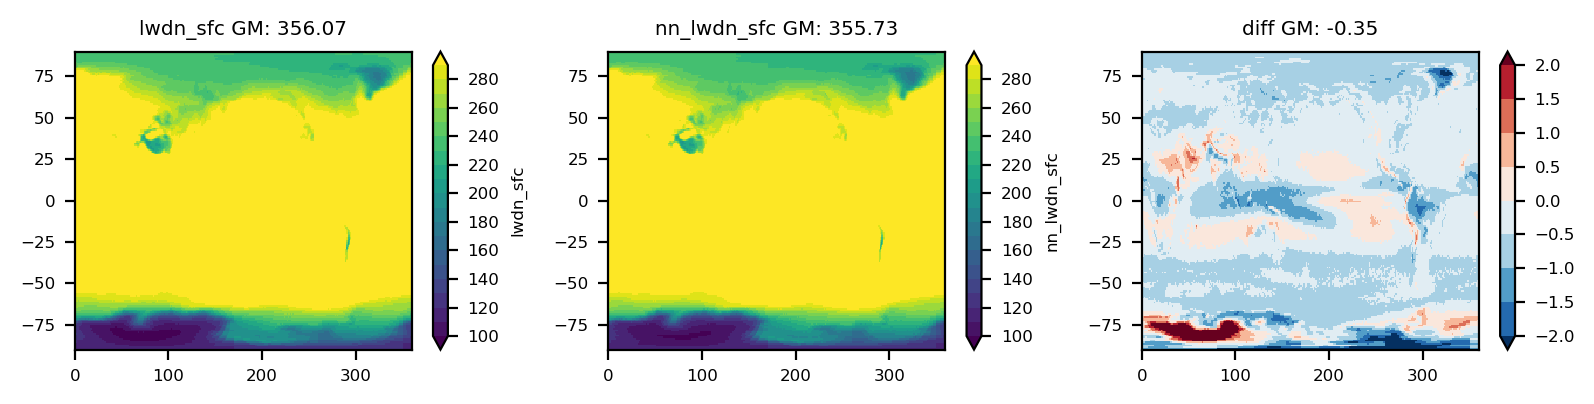

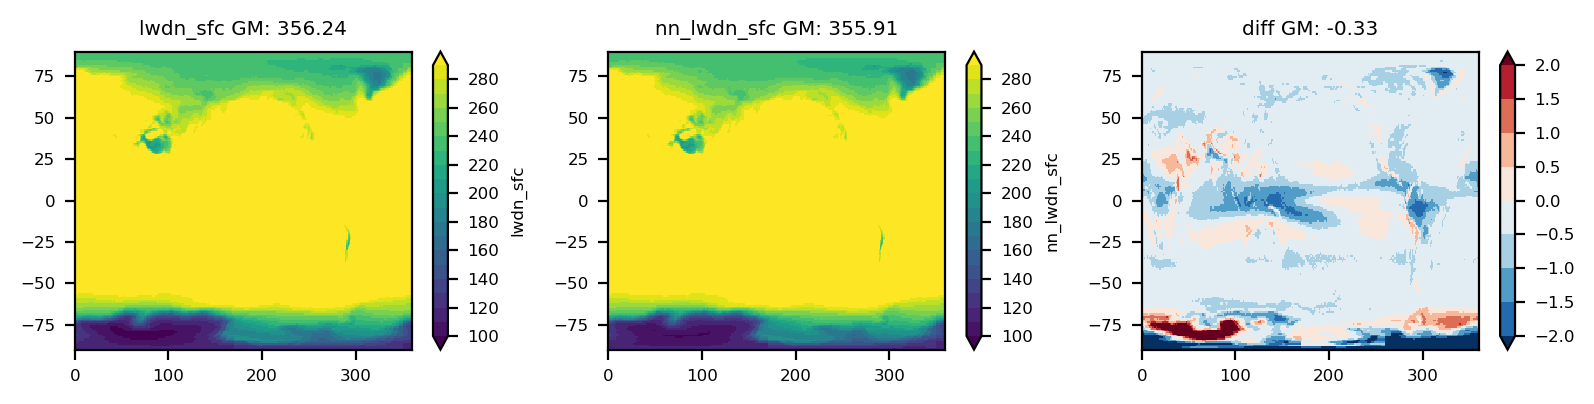

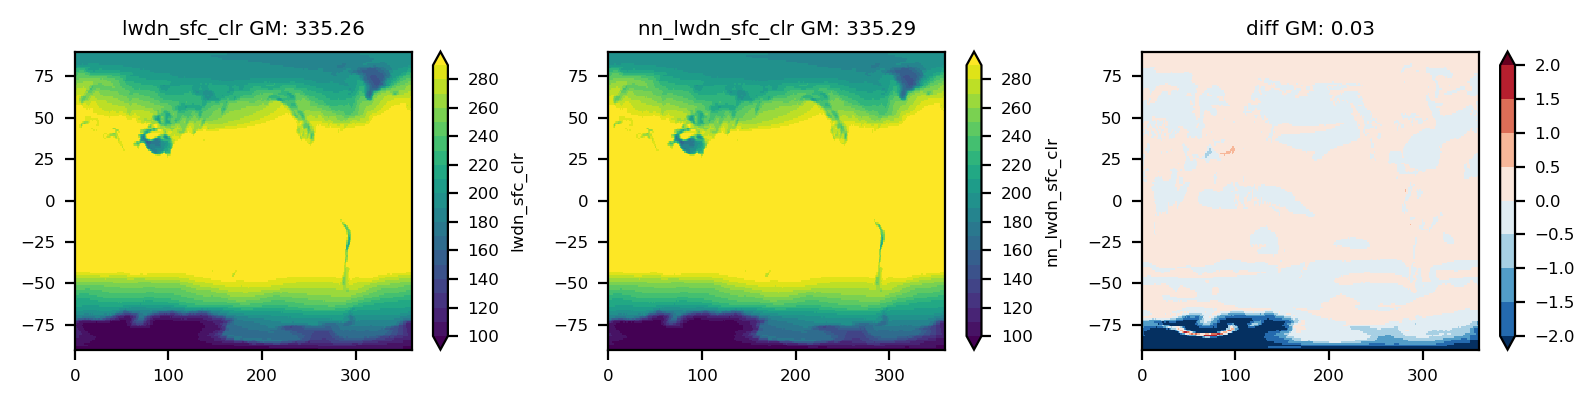

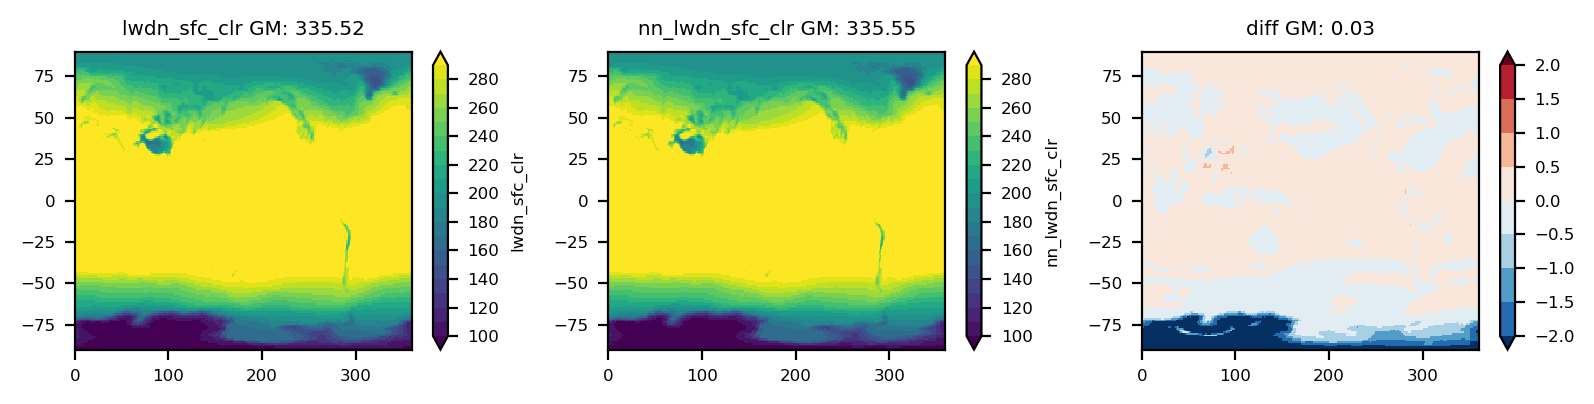

In [12]:
year_sel=np.arange(1975,1985)
time_sel = ds_nn_3h.time.dt.year.isin(year_sel)
print('warm test')
ds_list = [ds_ba_3h['olr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_olr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['olr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_olr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['olr_clr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_olr_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['olr_clr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_olr_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['lwdn_sfc'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_lwdn_sfc'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['lwdn_sfc'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_lwdn_sfc'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['lwdn_sfc_clr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_lwdn_sfc_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['lwdn_sfc_clr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_lwdn_sfc_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,300,10), dlevel = np.arange(-2,2.1,0.5)) 

clod test


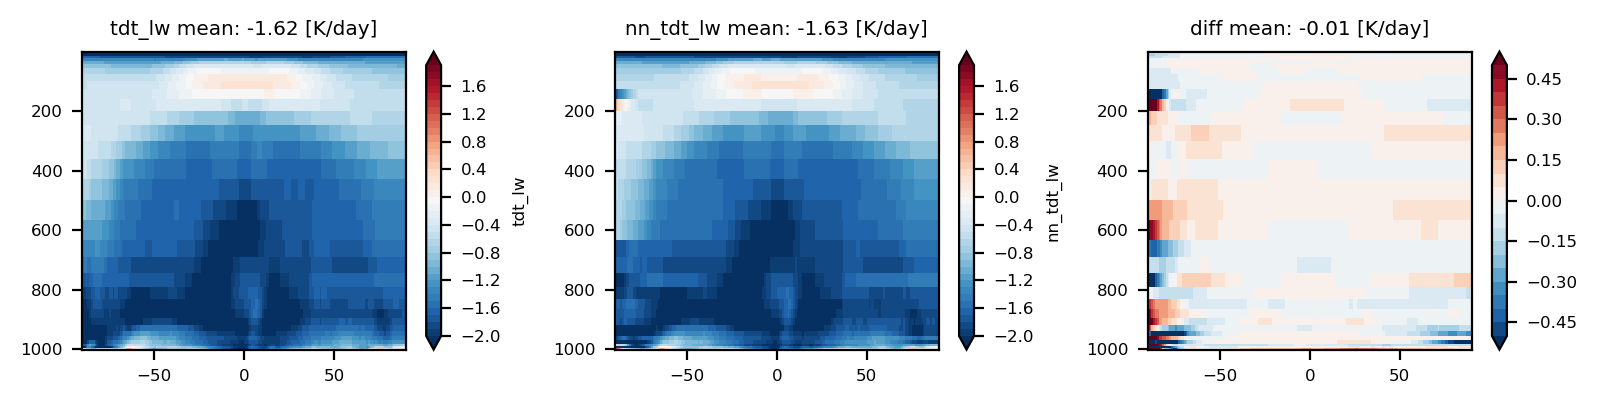

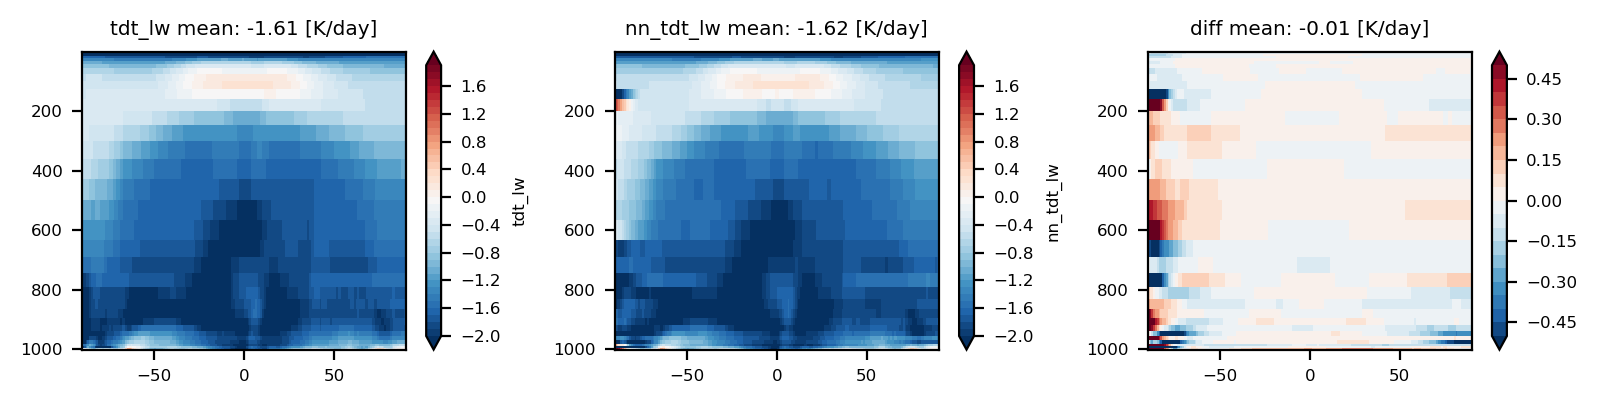

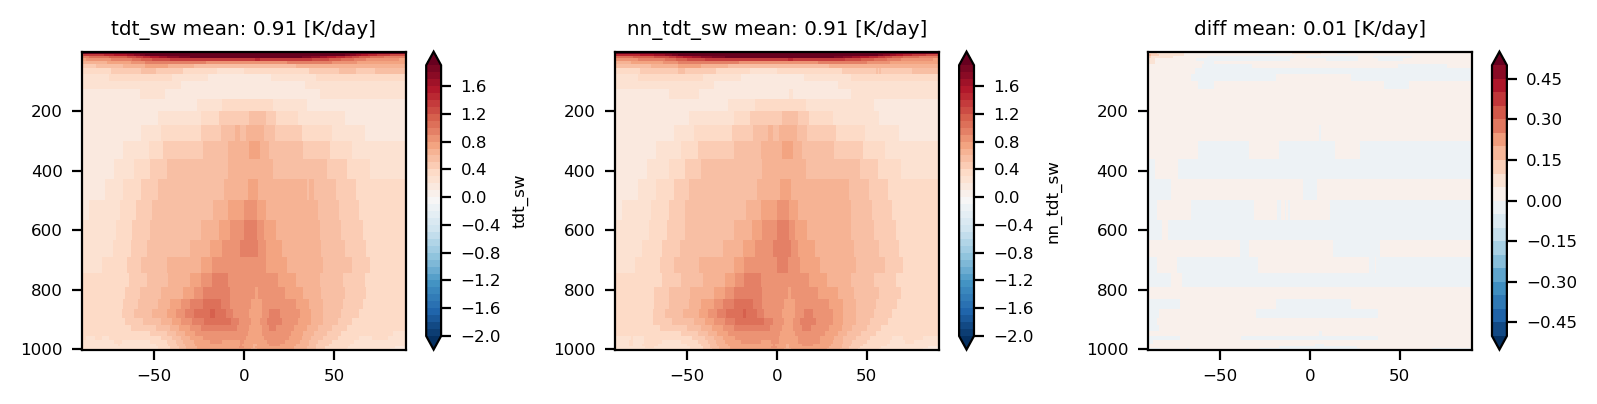

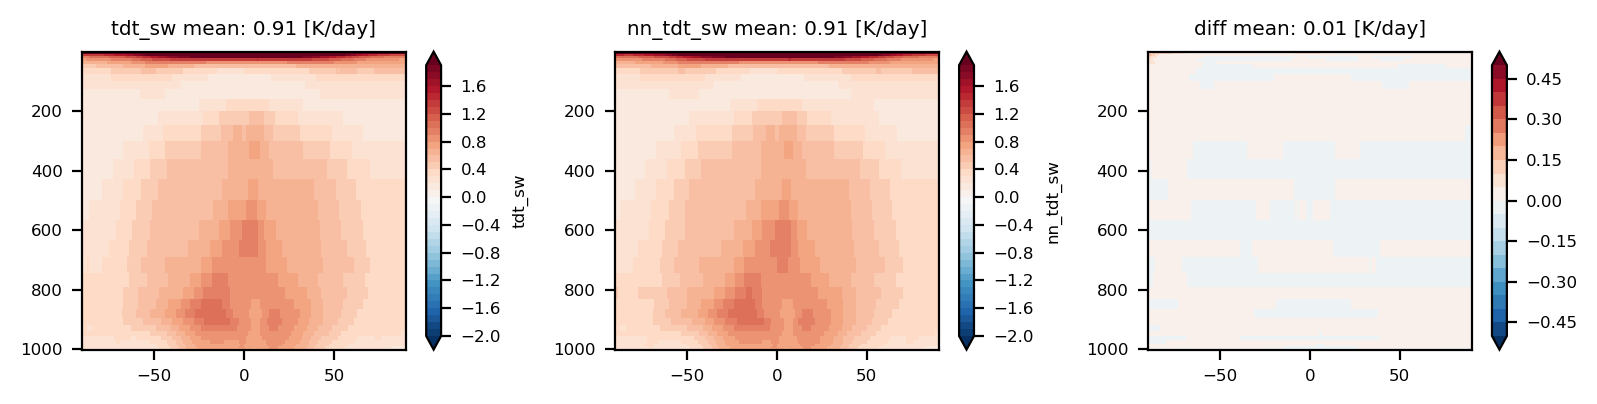

In [13]:
year_sel=np.arange(1965,1975)
time_sel = ds_nn_3h.time.dt.year.isin(year_sel)
print('clod test')
ds_list = [ds_ba_3h['tdt_lw'   ].isel(time=time_sel).mean(['time','lon']).load()*86400,
           ds_ba_3h['nn_tdt_lw'].isel(time=time_sel).mean(['time','lon']).load()*86400]
plot_zonal_tdt_diff(ds_list ) 
ds_list = [ds_nn_3h['tdt_lw'   ].isel(time=time_sel).mean(['time','lon']).load()*86400,
           ds_nn_3h['nn_tdt_lw'].isel(time=time_sel).mean(['time','lon']).load()*86400]
plot_zonal_tdt_diff(ds_list ) 

ds_list = [ds_ba_3h['tdt_sw'   ].isel(time=time_sel).mean(['time','lon']).load()*86400,
           ds_ba_3h['nn_tdt_sw'].isel(time=time_sel).mean(['time','lon']).load()*86400]
plot_zonal_tdt_diff(ds_list ) 
ds_list = [ds_nn_3h['tdt_sw'   ].isel(time=time_sel).mean(['time','lon']).load()*86400,
           ds_nn_3h['nn_tdt_sw'].isel(time=time_sel).mean(['time','lon']).load()*86400]
plot_zonal_tdt_diff(ds_list ) 

warm test


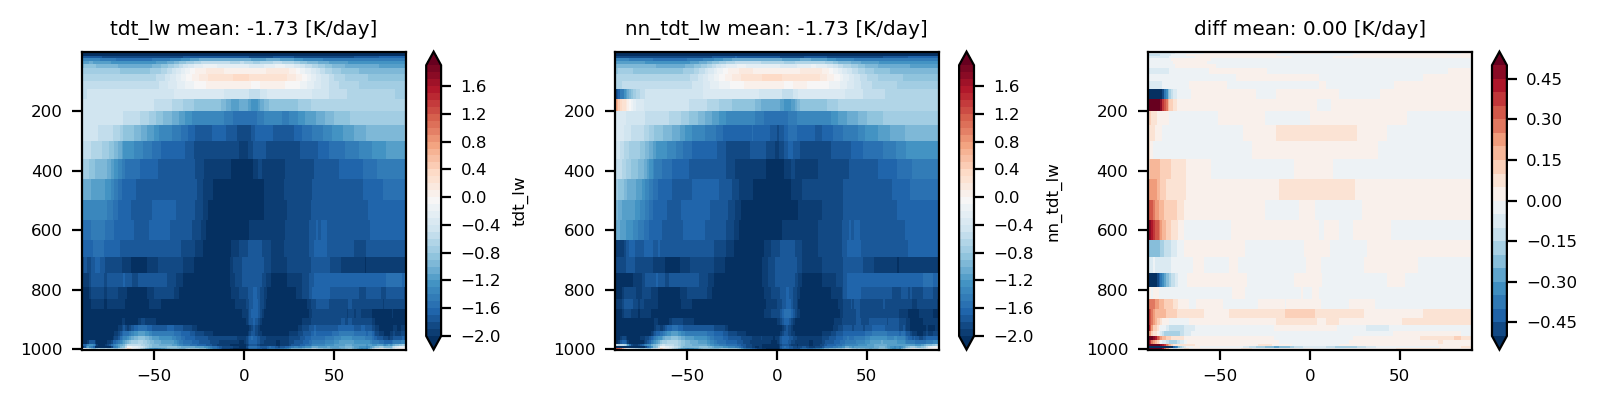

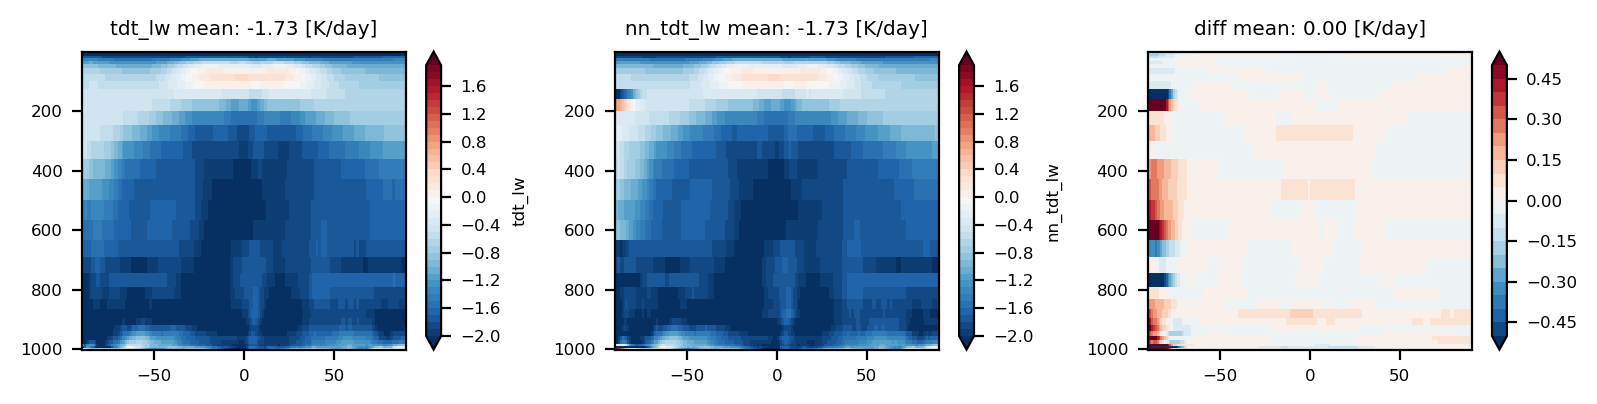

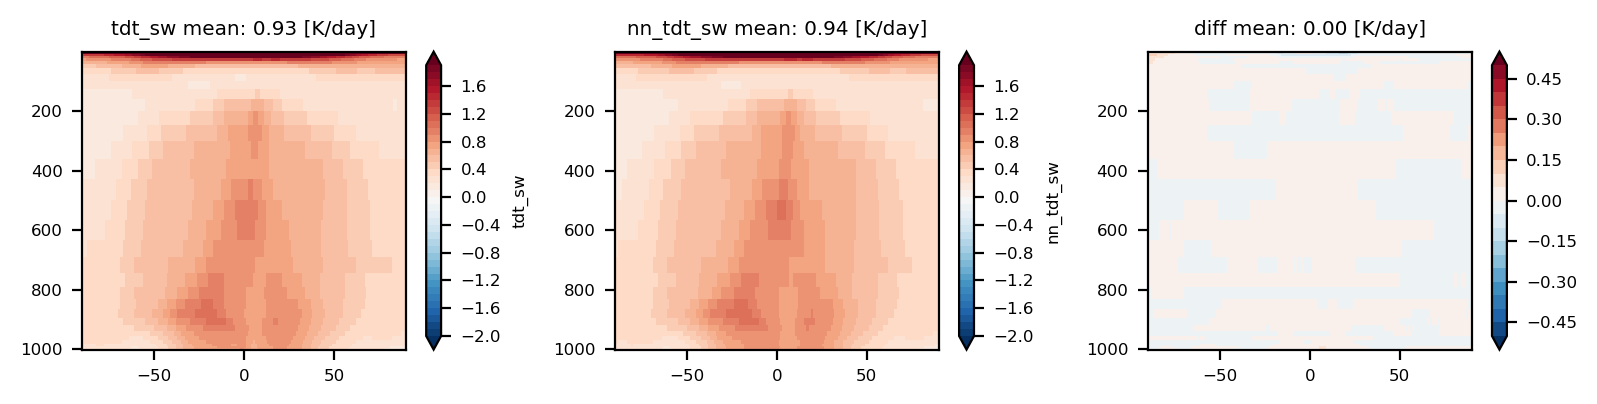

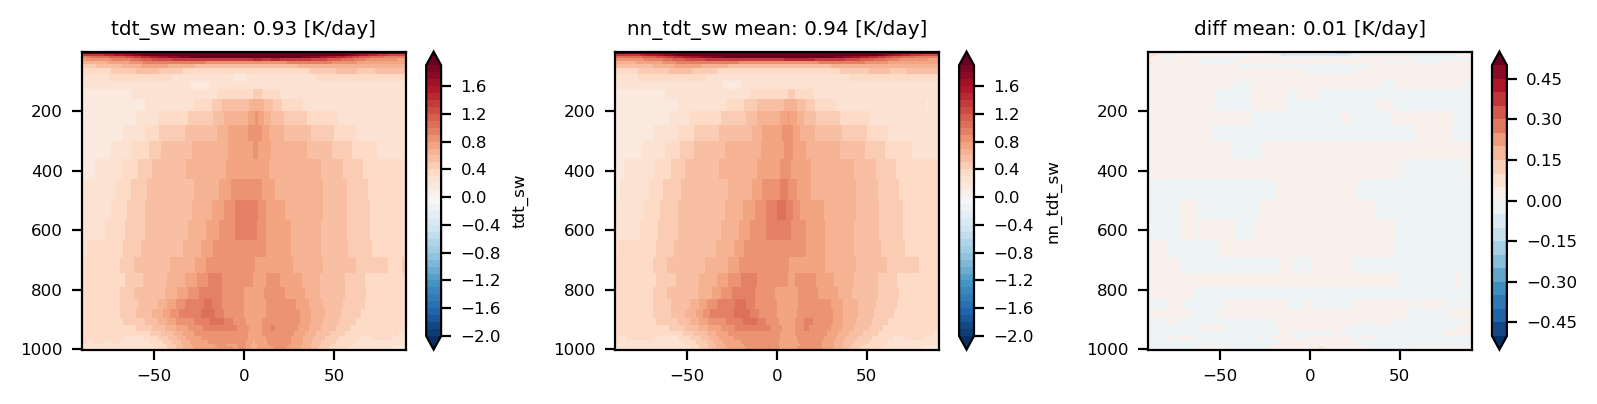

In [14]:
year_sel=np.arange(1975,1985)
time_sel = ds_nn_3h.time.dt.year.isin(year_sel)
print('warm test')
ds_list = [ds_ba_3h['tdt_lw'   ].isel(time=time_sel).mean(['time','lon']).load()*86400,
           ds_ba_3h['nn_tdt_lw'].isel(time=time_sel).mean(['time','lon']).load()*86400]
plot_zonal_tdt_diff(ds_list ) 
ds_list = [ds_nn_3h['tdt_lw'   ].isel(time=time_sel).mean(['time','lon']).load()*86400,
           ds_nn_3h['nn_tdt_lw'].isel(time=time_sel).mean(['time','lon']).load()*86400]
plot_zonal_tdt_diff(ds_list ) 

ds_list = [ds_ba_3h['tdt_sw'   ].isel(time=time_sel).mean(['time','lon']).load()*86400,
           ds_ba_3h['nn_tdt_sw'].isel(time=time_sel).mean(['time','lon']).load()*86400]
plot_zonal_tdt_diff(ds_list ) 
ds_list = [ds_nn_3h['tdt_sw'   ].isel(time=time_sel).mean(['time','lon']).load()*86400,
           ds_nn_3h['nn_tdt_sw'].isel(time=time_sel).mean(['time','lon']).load()*86400]
plot_zonal_tdt_diff(ds_list ) 

GM trend


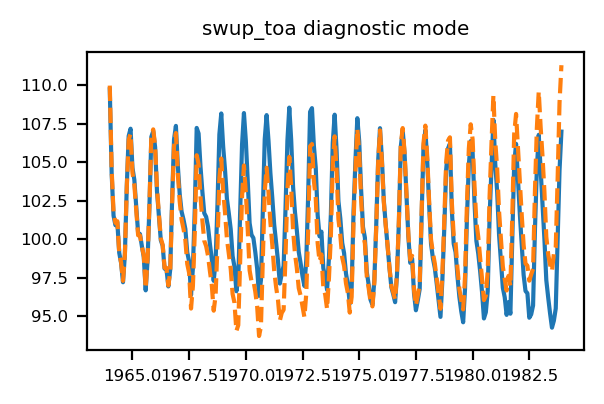

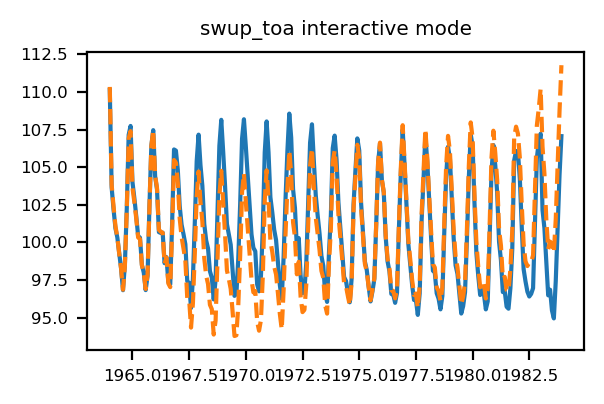

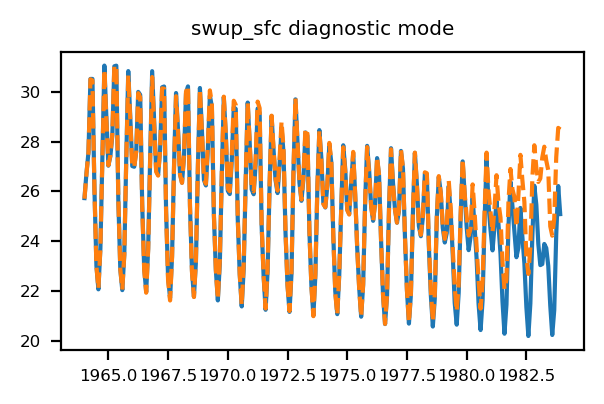

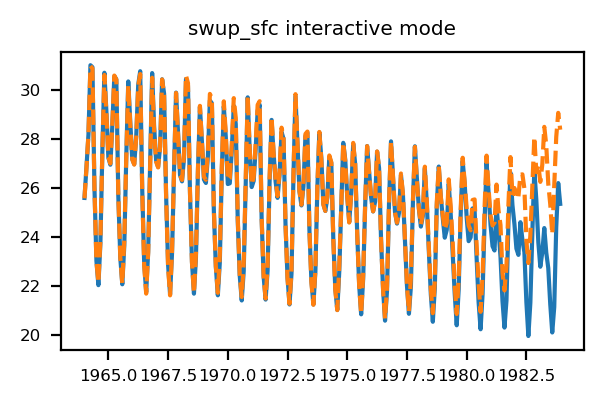

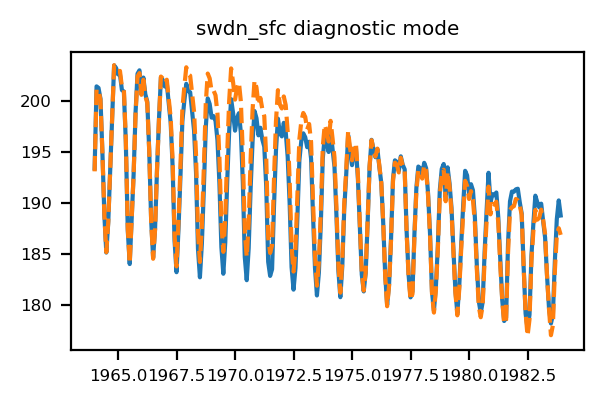

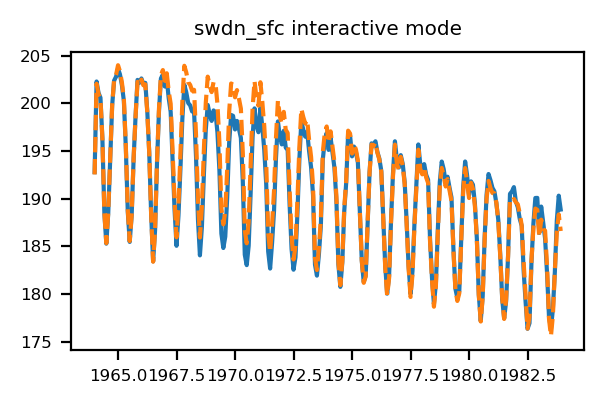

In [47]:
var = 'swup_toa' 
print('GM trend') 
ds_list = [ds_ba_3h[var],
           ds_ba_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' diagnostic mode') 
ds_list = [ds_nn_3h[var],
           ds_nn_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' interactive mode') 
var = 'swup_sfc' 
ds_list = [ds_ba_3h[var],
           ds_ba_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' diagnostic mode') 
ds_list = [ds_nn_3h[var],
           ds_nn_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' interactive mode') 
var = 'swdn_sfc' 
ds_list = [ds_ba_3h[var],
           ds_ba_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' diagnostic mode') 
ds_list = [ds_nn_3h[var],
           ds_nn_3h[f'nn_{var}']]
plot_GM_diff(ds_list, var + ' interactive mode') 

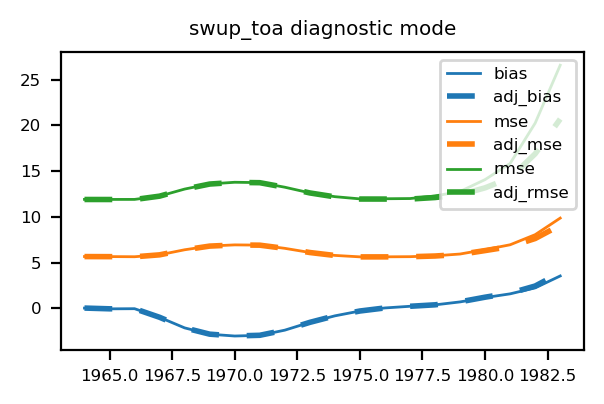

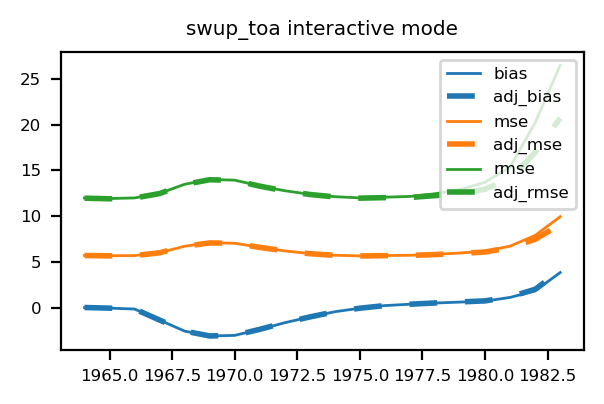

In [43]:
plot_GM_bias_mse_rmse_diff(ds_ba_3h,'swup_toa','swup_toa diagnostic mode')

plot_GM_bias_mse_rmse_diff(ds_nn_3h,'swup_toa','swup_toa interactive mode')

cold test


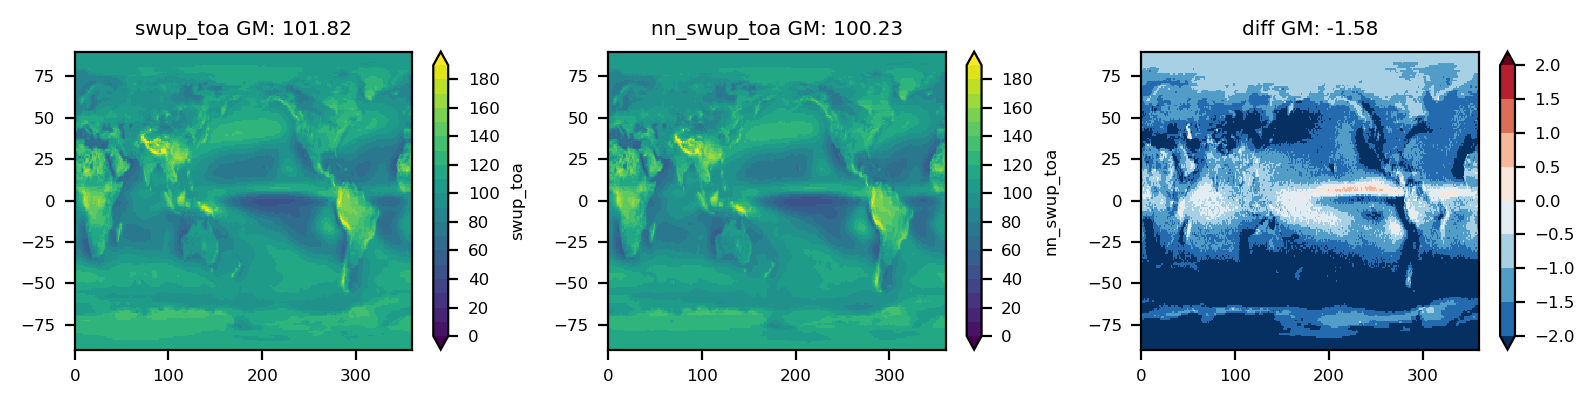

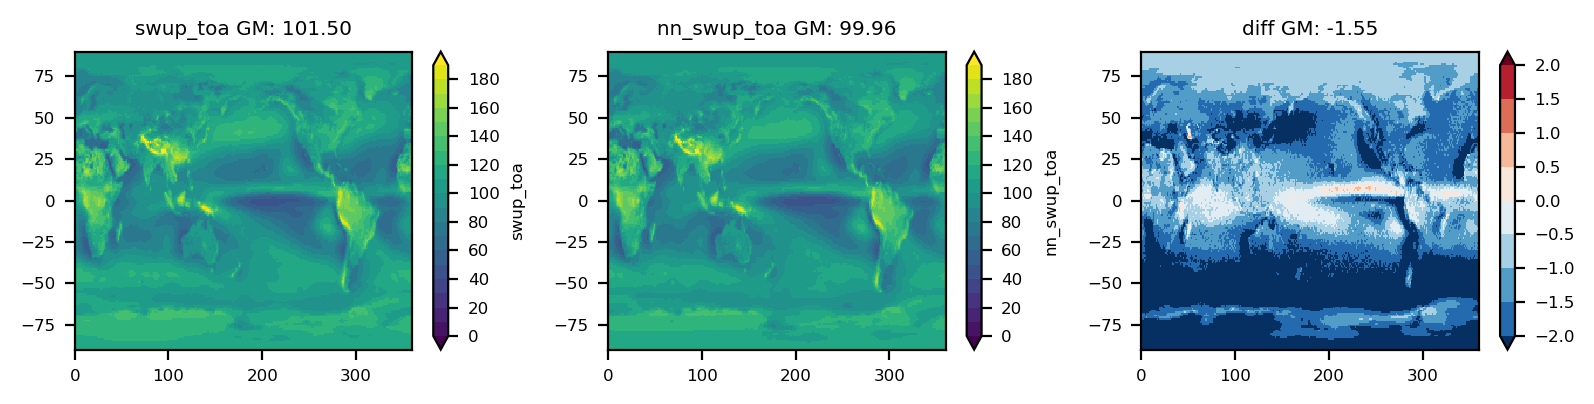

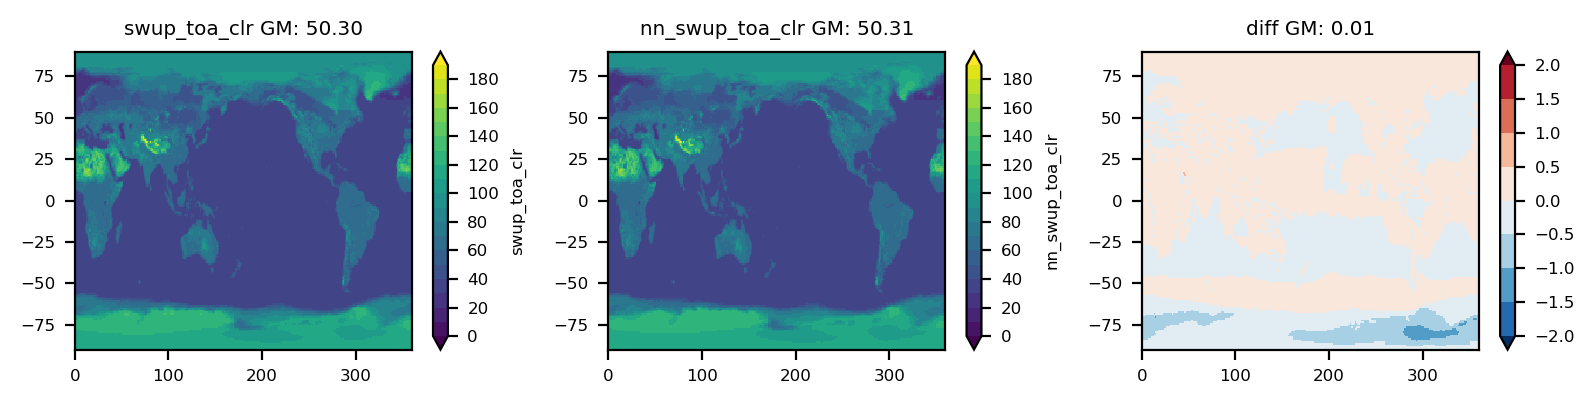

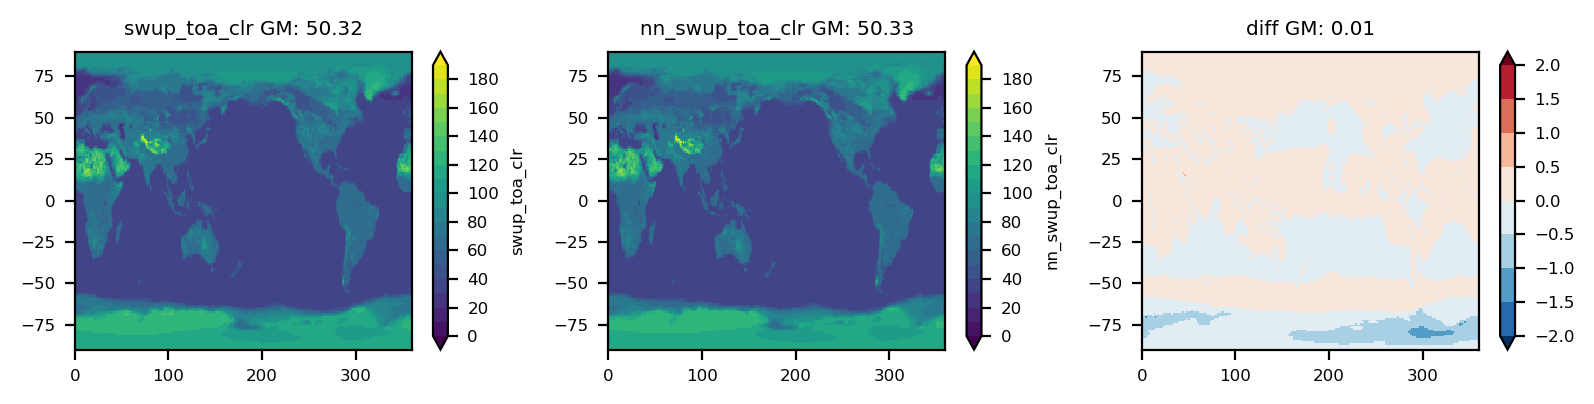

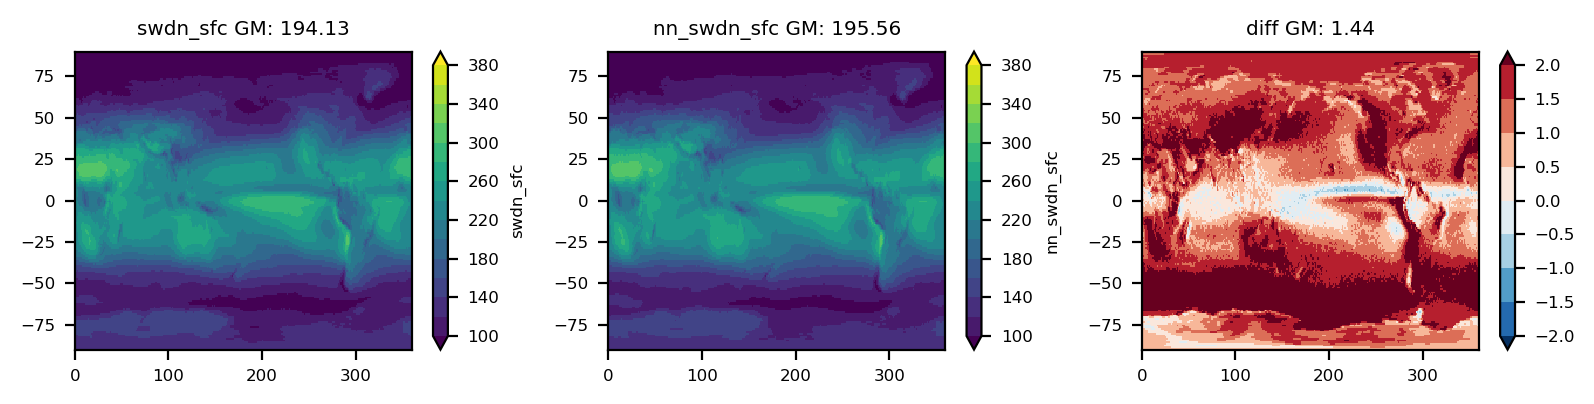

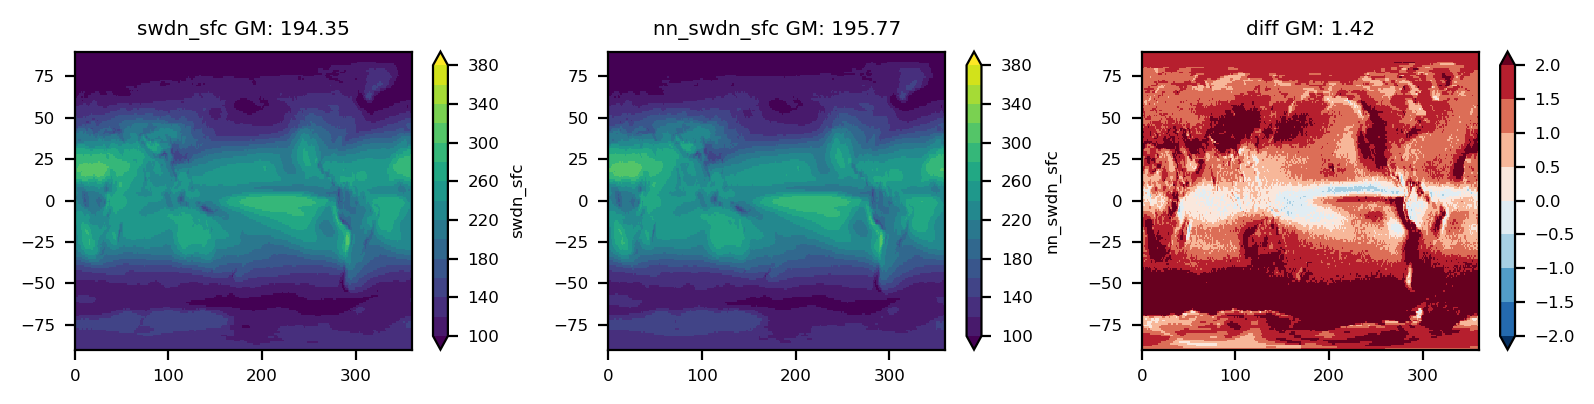

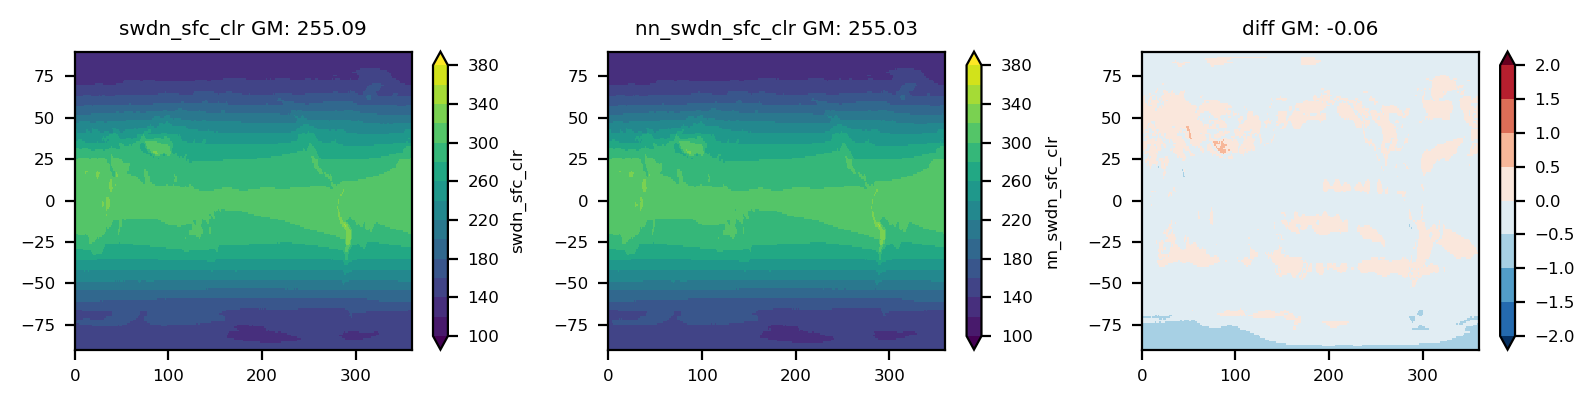

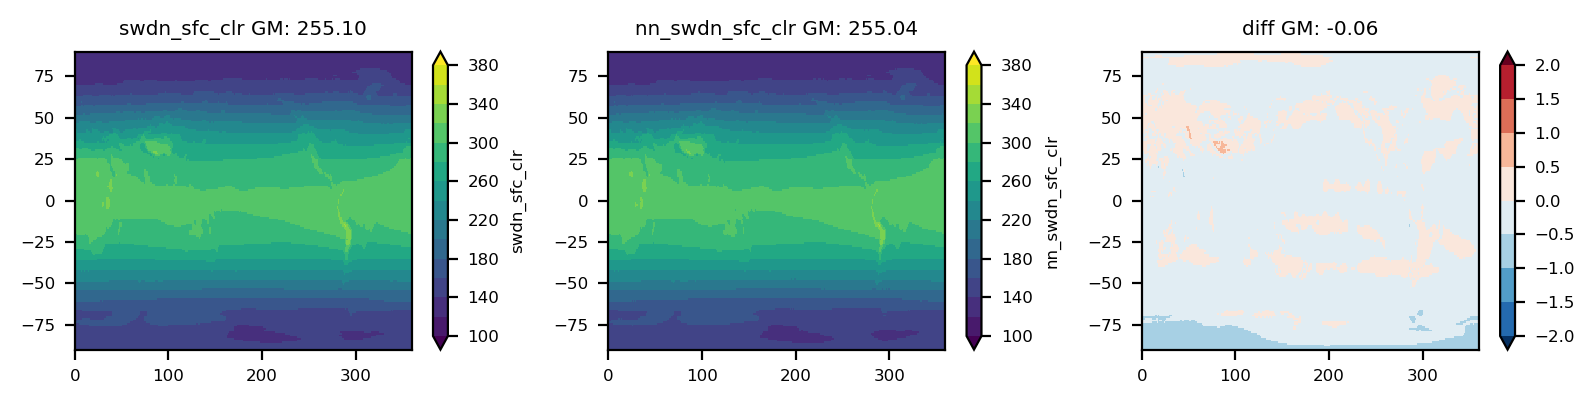

In [18]:
year_sel=np.arange(1965,1975)
time_sel = ds_nn_3h.time.dt.year.isin(year_sel)
print('cold test')
ds_list = [ds_ba_3h['swup_toa'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_swup_toa'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(0,200,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['swup_toa'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_swup_toa'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(0,200,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['swup_toa_clr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_swup_toa_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(0,200,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['swup_toa_clr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_swup_toa_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(0,200,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['swdn_sfc'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_swdn_sfc'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,400,20), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['swdn_sfc'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_swdn_sfc'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,400,20), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['swdn_sfc_clr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_swdn_sfc_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,400,20), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['swdn_sfc_clr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_swdn_sfc_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,400,20), dlevel = np.arange(-2,2.1,0.5)) 

warm test


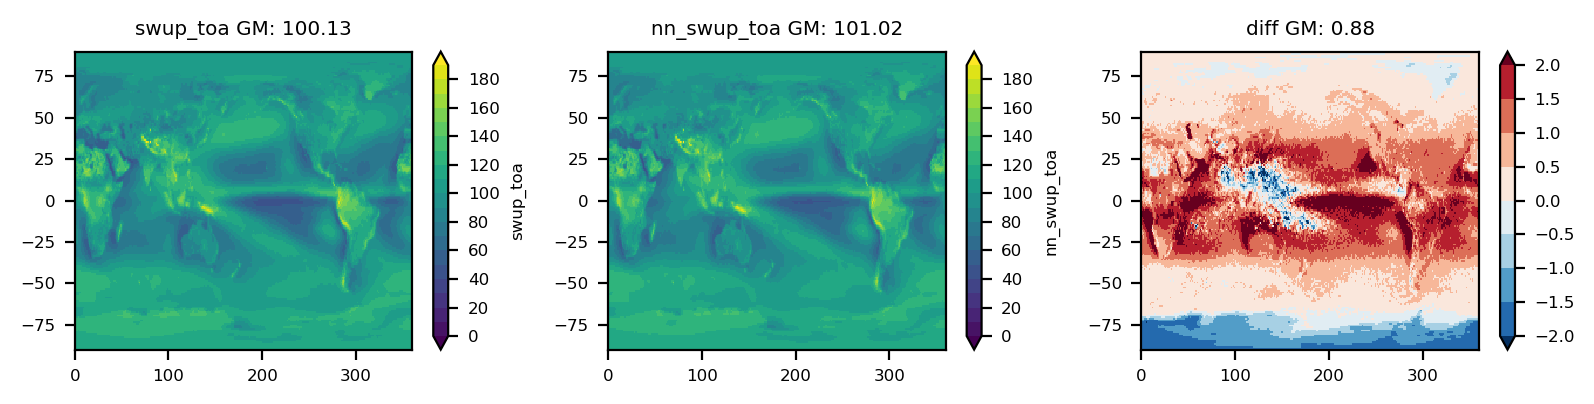

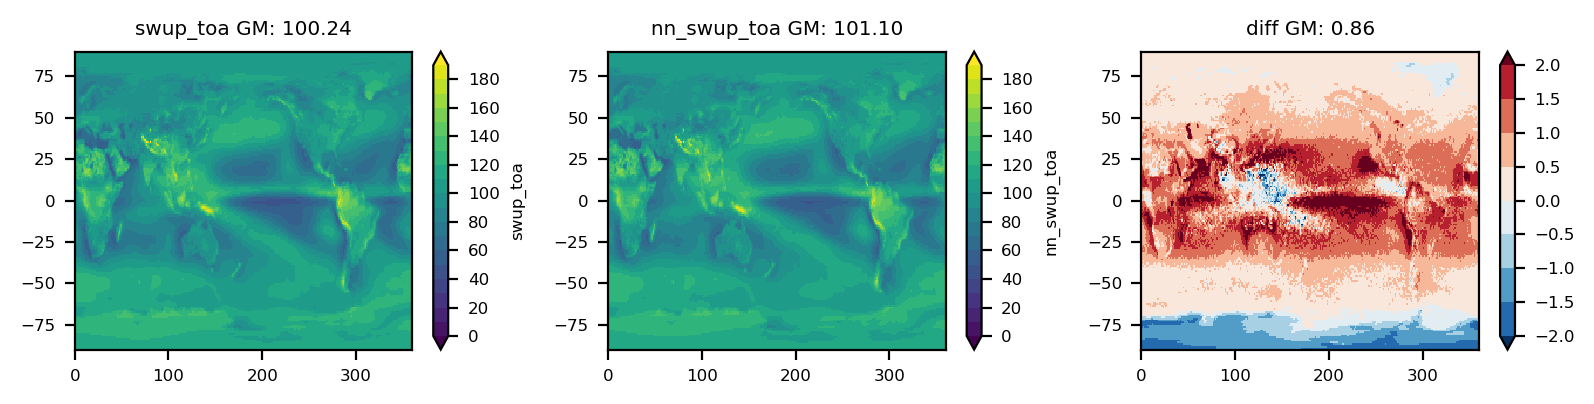

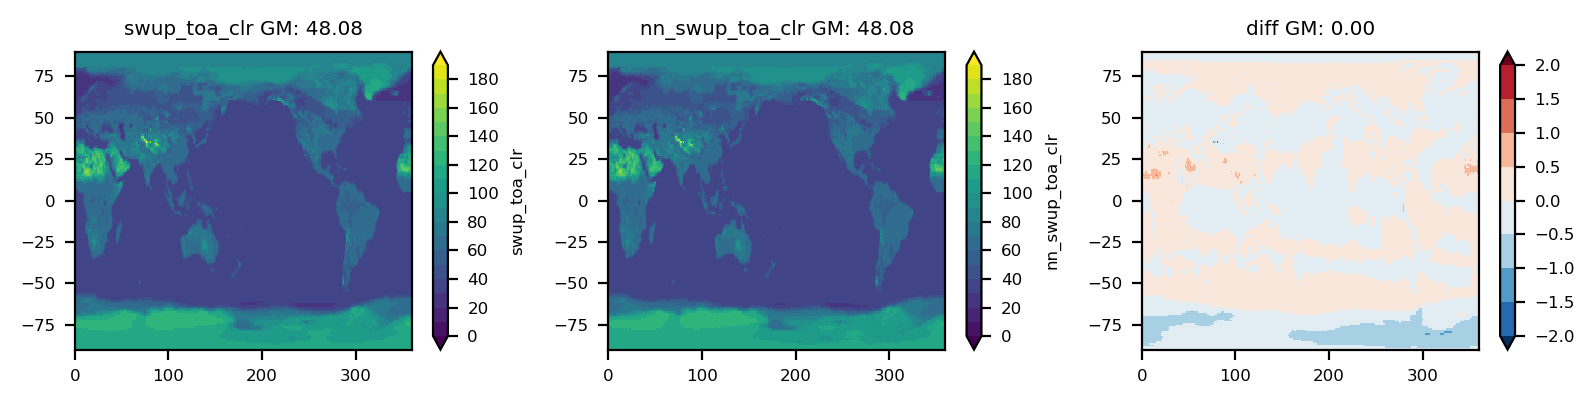

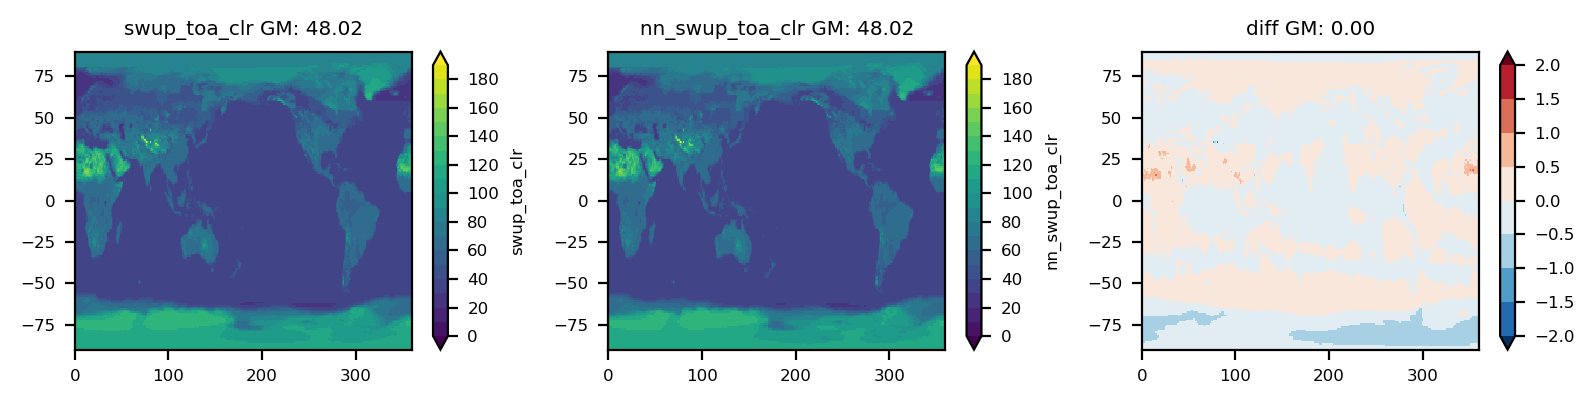

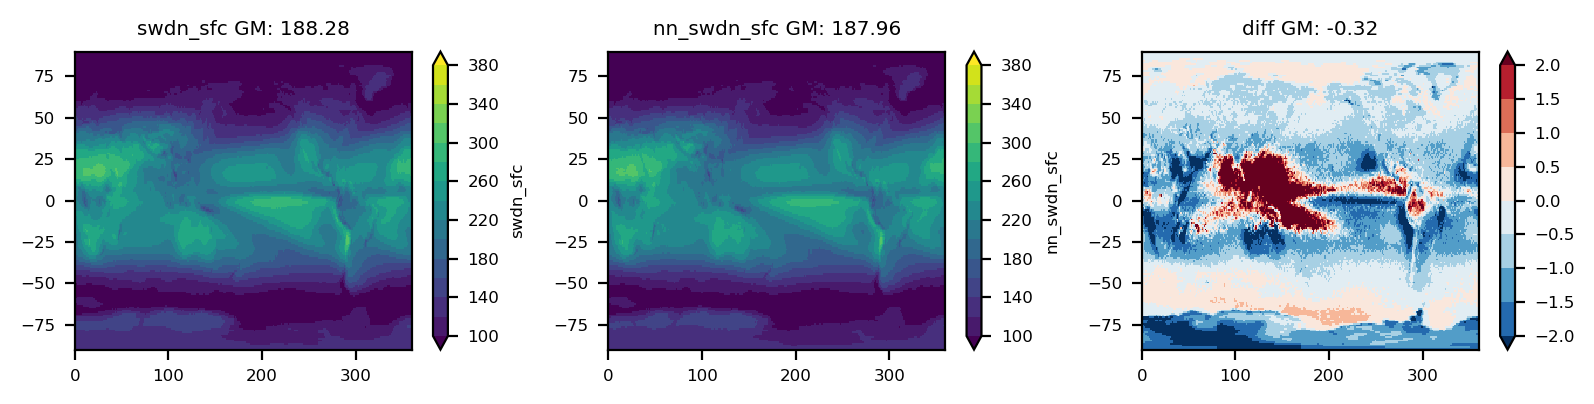

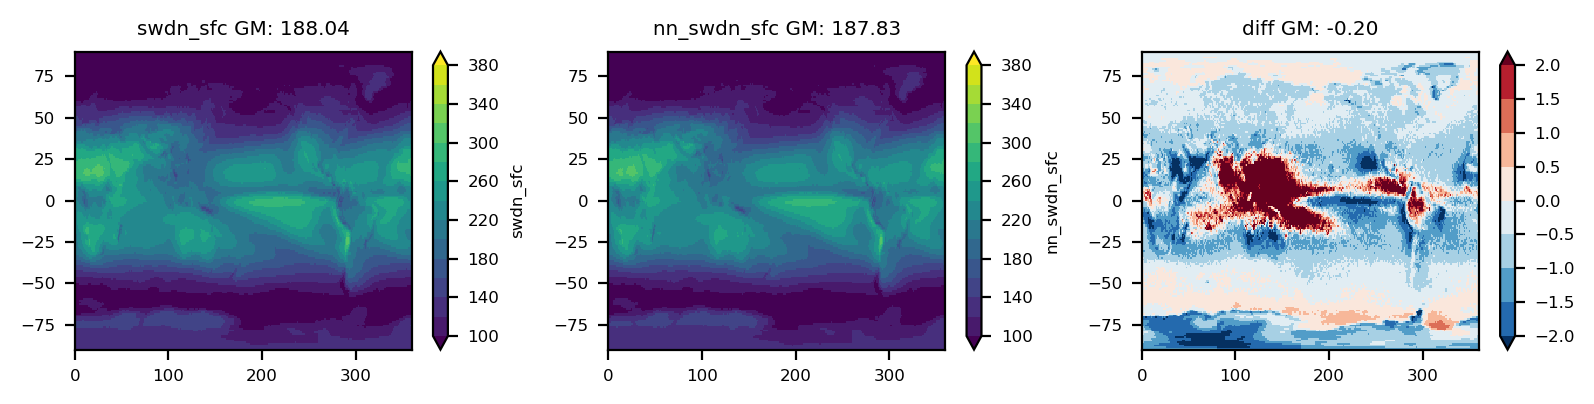

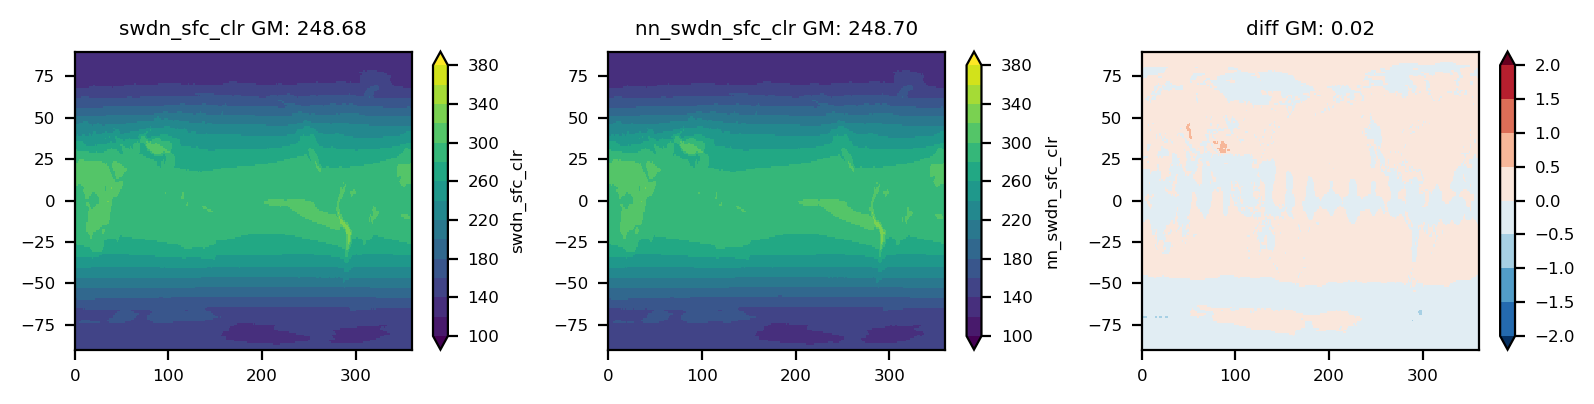

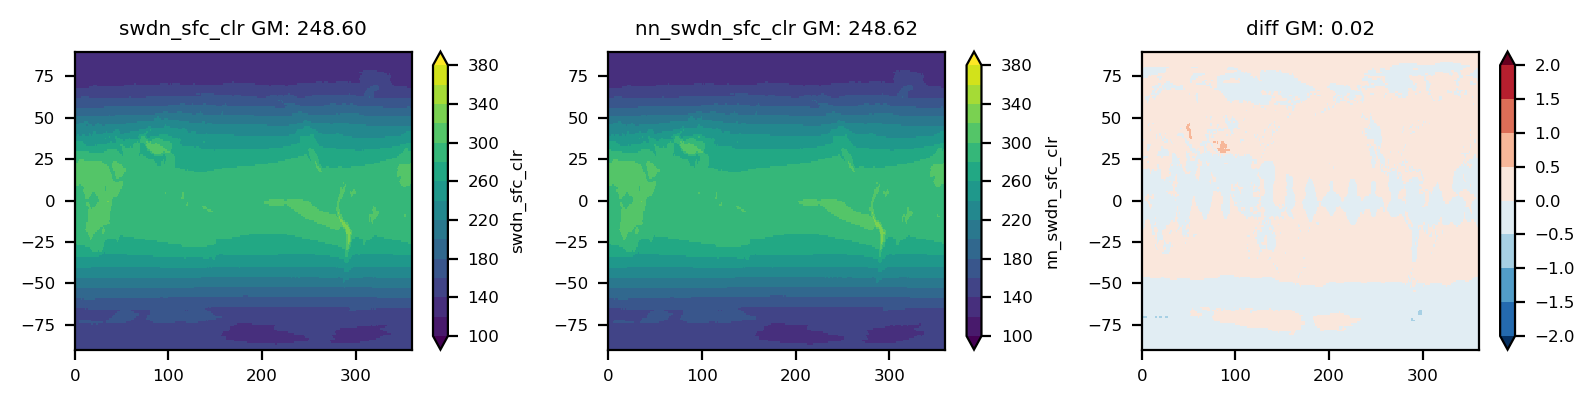

In [19]:
year_sel=np.arange(1975,1985)
time_sel = ds_nn_3h.time.dt.year.isin(year_sel)
print('warm test')
ds_list = [ds_ba_3h['swup_toa'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_swup_toa'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(0,200,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['swup_toa'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_swup_toa'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(0,200,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['swup_toa_clr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_swup_toa_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(0,200,10), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['swup_toa_clr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_swup_toa_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(0,200,10), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['swdn_sfc'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_swdn_sfc'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,400,20), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['swdn_sfc'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_swdn_sfc'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,400,20), dlevel = np.arange(-2,2.1,0.5)) 

ds_list = [ds_ba_3h['swdn_sfc_clr'].isel(time=time_sel).mean('time').load(),
           ds_ba_3h['nn_swdn_sfc_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,400,20), dlevel = np.arange(-2,2.1,0.5)) 
ds_list = [ds_nn_3h['swdn_sfc_clr'].isel(time=time_sel).mean('time').load(),
           ds_nn_3h['nn_swdn_sfc_clr'].isel(time=time_sel).mean('time').load()]
plot_ds12_diff(ds_list,level = np.arange(100,400,20), dlevel = np.arange(-2,2.1,0.5)) 